# Cryptocurrency Analysis

## Modules used in this assignment

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import AdaBoostClassifier as ABC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.neural_network import MLPClassifier as NeuralNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef as mcc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
labelencoder = LabelEncoder()

input_file = 'data/ethereum_price_new.csv'

def two_scales(ax1, title, time, data1, data2, c1, c2):
    plt.title(str(title))
    ax2 = ax1.twinx()
    ax1.plot(time, data1, color=c1)
    ax2.plot(time, data2, color=c2)
    return ax1, ax2

## Random Forest

#### Settings

In [ ]:
# attribute to predict (binary)
attribute = 'increase_flag'

# train/test split
split = 0.8

# number of features available ##TODO how was this selected? Data and binary not considered?
num_feats = 7

#### Training and Testing

In [ ]:
# load and format data
df = pd.read_csv(input_file)
outcomes = np.array(['no','yes'])
names = list(df.columns.values)

# preprocessing: factorize date column
# for i in range(1):
#     df.iloc[:,i] = labelencoder.fit_transform(df.iloc[:,i])
    
# train/test split
df['is_train'] = np.random.uniform(0, 1, len(df)) <= split
train, test = df[df['is_train']==True], df[df['is_train']==False]

# features (using all)
features = df.columns[1:num_feats]

# random forest
# forest = RFC(n_estimators=175, criterion='gini', max_features='sqrt', max_depth=12,
#             min_samples_split=4, min_samples_leaf=2, oob_score=True)
forest = RFC(n_estimators=175, criterion='gini', n_jobs=2)
forest.fit(train[features], train[attribute])

# predictions and plotting
preds = outcomes[forest.predict(test[features])]
accuracy = accuracy_score(test[attribute], forest.predict(test[features]), 
                          normalize=True, sample_weight=None) * 100
print("We accurately predicted the next day's price movement with %.2f%% accuracy.\n" % accuracy)

# confusion matrix
print(pd.crosstab(index=test[attribute], columns=preds, 
                  rownames=['actual'], colnames=['preds']))

# matthews correction coefficient
coeff = mcc(test[attribute],forest.predict(test[features]))
print("MCC = %.2f" % coeff)

# plot feature importance
importances = forest.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], 
         color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

#### Feature Selection

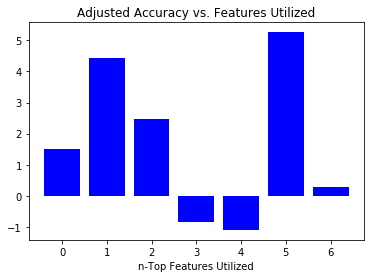

By using 6 of 7 features, we attained 5.26% adjusted accuracy



In [6]:
accuracy_l = []

for i in range(1,num_feats+1):
    # how many?
    feats_to_keep = i

    # reduce features
    top_features = df.columns[indices[-1*int(feats_to_keep):]]

    # random forest
    forest = RFC(n_jobs=2,n_estimators=100)
    forest.fit(train[top_features], train[attribute])
    
    # predictions and plotting
    preds = forest.predict(test[top_features])
    mattcc = mcc(test[attribute],preds)
    accuracy_l.append(accuracy_score(test[attribute], preds, normalize=True, sample_weight=None) * mattcc * 100)

# visual inspection of accuracy W.R.T 
plt.title('Adjusted Accuracy vs. Features Utilized')
plt.bar(range(num_feats), accuracy_l, color='b', align='center')
plt.xlabel('n-Top Features Utilized')
plt.show()

# optimal number of features to keep
best_n = accuracy_l.index(max(accuracy_l))
print("By using %d of %d features, we attained %.2f%% adjusted accuracy\n" % (best_n + 1,num_feats,accuracy_l[best_n]))
feats_to_keep = best_n

# FOR NEXT CELL

# reduce features
top_features = df.columns[indices[-1*int(feats_to_keep):]]

# random forest
forest = RFC(n_jobs=4,n_estimators=200)
forest.fit(train[top_features], train[attribute])
preds = forest.predict(test[top_features])

## Adaboost

#### Settings

In [7]:
# attribute to predict (binary)
attribute = 'increase_flag'

# train/test split
split = 0.8

# number of features available
num_feats = 7

#### Training and Testing

AdaBoost Accuracy: 58.82%
MCC = 0.13


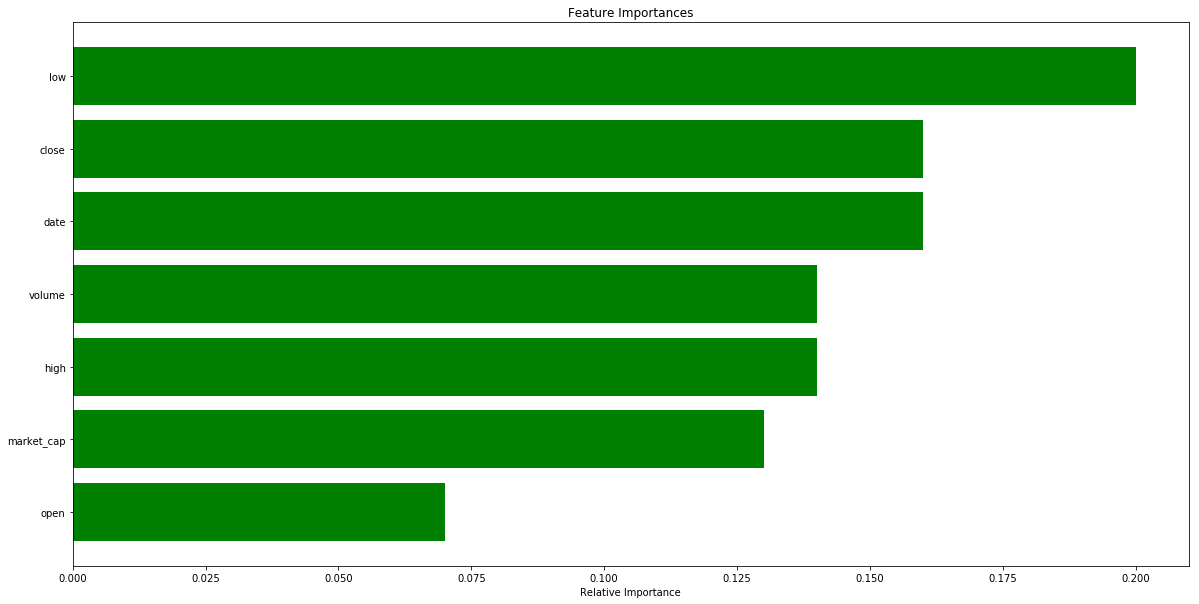

In [11]:
# dataset
df_ada = pd.read_csv(input_file)

# preprocessing: factorize date column
# for i in [0]:
#     df_ada.iloc[:,i] = labelencoder.fit_transform(df_ada.iloc[:,i])

# train/test split
df_ada['is_train'] = np.random.uniform(0, 1, len(df_ada)) <= split
train, test = df_ada[df_ada['is_train']==True], df_ada[df_ada['is_train']==False]

# features (using all)
features = df_ada.columns[0:num_feats]

# training and testing
adaboost = ABC(n_estimators=100).fit(train[features], train[attribute])
print("AdaBoost Accuracy: %.2f%%" % (adaboost.score(test[features], test[attribute])*100.0))

# matthews correction coefficient
coeff = mcc(test[attribute],adaboost.predict(test[features]))
print("MCC = %.2f" % coeff)

# plot feature importance
importances = adaboost.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], 
         color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

#### Feature Selection

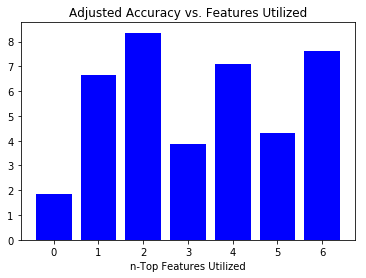

By using 3 of 7 features, we attained 8.36% adjusted accuracy



In [12]:
accuracy_l = []

for i in range(1,num_feats+1):
    # how many?
    feats_to_keep = i

    # reduce features
    top_features = df_ada.columns[indices[-1*int(feats_to_keep):]]

    # adaboost
    adaboost = ABC(n_estimators=100).fit(train[features], train[attribute])
    adaboost.fit(train[top_features], train[attribute])
    
    # predictions and plotting
    coeff = mcc(test[attribute],adaboost.predict(test[top_features]))
    accuracy_l.append(adaboost.score(test[top_features], test[attribute]) * coeff * 100.0)

plt.title('Adjusted Accuracy vs. Features Utilized')
plt.bar(range(num_feats), accuracy_l, color='b', align='center')
plt.xlabel('n-Top Features Utilized')
plt.show()

best_n = accuracy_l.index(max(accuracy_l))

print("By using %d of %d features, we attained %.2f%% adjusted accuracy\n" % (best_n + 1,num_feats,accuracy_l[best_n]))

## Gradient Boost

#### Settings

In [13]:
# attribute to predict (binary)
attribute = 'increase_flag'

# train/test split
split = 0.8

# number of features available
num_feats = 7

#### Training and Testing

GradBoost Accuracy: 56.57%
MCC = 0.11


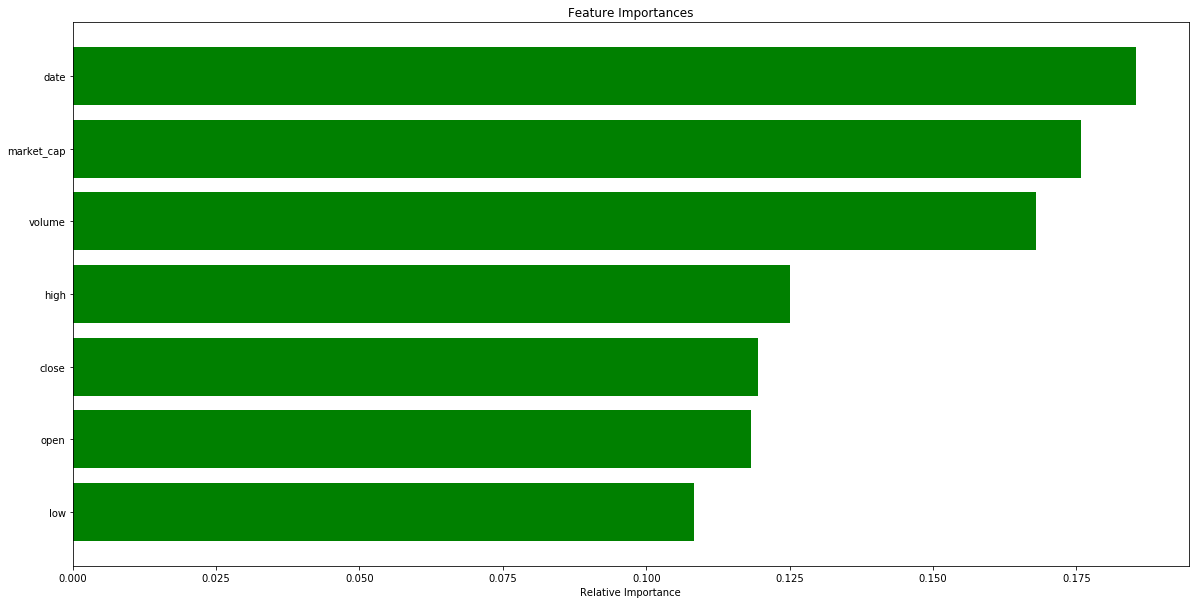

In [14]:
# dataset
df_gb = pd.read_csv(input_file)

# preprocessing: factorize date column
# for i in [0]:
#     df_gb.iloc[:,i] = labelencoder.fit_transform(df_gb.iloc[:,i])

# train/test split
df_gb['is_train'] = np.random.uniform(0, 1, len(df_gb)) <= split
train, test = df_gb[df_gb['is_train']==True], df_gb[df_gb['is_train']==False]

# features (using all)
features = df_gb.columns[0:num_feats]

# training and testing
gradboost = GBC(n_estimators=100, learning_rate=0.01, max_depth=10, random_state=5)
gradboost.fit(train[features], train[attribute])
print("GradBoost Accuracy: %.2f%%" % (gradboost.score(test[features], test[attribute])*100.0))

# matthews correction coefficient
coeff = mcc(test[attribute],gradboost.predict(test[features]))
print("MCC = %.2f" % coeff)

# feature importance
importances = gradboost.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], 
         color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

#### Feature Selection

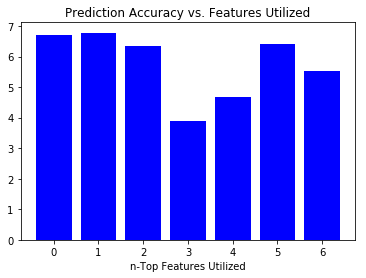

By using 2 of 7 features, we attained 6.78% accuracy



In [15]:
accuracy_l = []
for i in range(1,num_feats+1):
    # how many?
    feats_to_keep = i
    # reduce features
    top_features = df_gb.columns[indices[-1*int(feats_to_keep):]]
    # gradient boost
    gradboost = GBC(n_estimators=100, learning_rate=0.01, max_depth=10, random_state=5)
    gradboost.fit(train[top_features], train[attribute])    
    # predictions and plotting
    coeff = mcc(test[attribute],gradboost.predict(test[top_features]))
    accuracy_l.append(gradboost.score(test[top_features], test[attribute]) * coeff * 100.0)

# plot feature selection results
plt.title('Prediction Accuracy vs. Features Utilized')
plt.bar(range(num_feats), accuracy_l, color='b', align='center')
plt.xlabel('n-Top Features Utilized')
plt.show()

# optimal number of features
best_n = accuracy_l.index(max(accuracy_l))
print("By using %d of %d features, we attained %.2f%% accuracy\n" % (best_n + 1,num_feats,accuracy_l[best_n]))

## Neural Network (MLP)

#### Settings

In [22]:
# attribute to predict (binary)
attribute = 'increase_flag'

# train/test split
split = 0.8

# number of features available
num_feats = 7

#### Training and Testing

In [32]:
# dataset
df_nn = pd.read_csv(input_file)

# preprocessing: factorize date column
# for i in [0]:
#     df_nn.iloc[:,i] = labelencoder.fit_transform(df_nn.iloc[:,i])

# train/test split
df_nn['is_train'] = np.random.uniform(0, 1, len(df_nn)) <= split
train, test = df_nn[df_nn['is_train']==True], df_nn[df_nn['is_train']==False]

# features (using all)
features = df_nn.columns[0:num_feats]

# transformations
scaler = StandardScaler()  
scaler.fit(train[features])  
train[features] = scaler.transform(train[features])  
test[features] = scaler.transform(test[features])  

# predict whether price will drop more than 5% tomorrow
nn = NeuralNet(solver='lbfgs', learning_rate_init=1e-3, alpha=1e-5, hidden_layer_sizes=(100,5), random_state=1, verbose=False)
nn.fit(train[features], train[attribute])
print("Neuralnet Accuracy: %.2f%%" % (nn.score(test[features], test[attribute])*100.0))

# matthews correction coefficient
coeff = mcc(test[attribute],nn.predict(test[features]))
print("MCC = %.2f" % coeff)


# # predict whether price will drop more than 5% tomorrow
# nn.fit(train[features], train[attribute])
# large_price_drop_prediction_5 = nn.predict(test[features])
# probs_5_drop = nn.predict_proba(test[features])
# print(nn.score(test[features], test[attribute]))

# # predict whether price will rise more than 5% tomorrow
# nn.fit(train[features], train[attribute])
# large_price_gain_prediction_5 = nn.predict(test[features])
# probs_5_gain = nn.predict_proba(test[features])
# print(nn.score(test[features], test[attribute]))

# predict whether price will increase or decrease
# nn.fit(train[features], train[attribute])
# price_increases_tomorrow = nn.predict(test[features])
# probs_inc = nn.predict_proba(test[features])
# print(nn.score(test[features], test[attribute]))

# # predict whether price will rise more than 5% tomorrow
# nn.fit(train[features], train['2_gain_tomorrow'])
# large_price_gain_prediction_2 = nn.predict(test[features])
# probs_2_gain = nn.predict_proba(test[features])
# print(nn.score(test[features], test['2_gain_tomorrow']))

# nn.fit(train[features], train['2_drop_tomorrow'])
# large_price_drop_prediction_2 = nn.predict(test[features])
# probs_2_drop = nn.predict_proba(test[features])
# print(nn.score(test[features], test['2_drop_tomorrow']))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

Neuralnet Accuracy: 53.93%
MCC = 0.07


#### Feature Selection

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


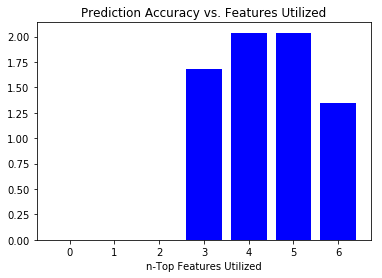

By using 6 of 7 features, we attained 2.04% accuracy



In [33]:
accuracy_l = []
for i in range(1,num_feats+1):
    # how many?
    feats_to_keep = i
    # reduce features
    top_features = df_nn.columns[indices[-1*int(feats_to_keep):]]
    # gradient boost
    nn = NeuralNet()
    nn.fit(train[top_features], train[attribute])    
    # predictions and plotting
    coeff = mcc(test[attribute],nn.predict(test[top_features]))
    accuracy_l.append(nn.score(test[top_features], test[attribute]) * coeff * 100.0)

# plot feature selection results
plt.title('Prediction Accuracy vs. Features Utilized')
plt.bar(range(num_feats), accuracy_l, color='b', align='center')
plt.xlabel('n-Top Features Utilized')
plt.show()

# optimal number of features
best_n = accuracy_l.index(max(accuracy_l))
print("By using %d of %d features, we attained %.2f%% accuracy\n" % (best_n + 1,num_feats,accuracy_l[best_n]))